In [17]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
import seaborn as sns
from tqdm import tqdm
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

Files already downloaded and verified


In [19]:
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops

estimator = torch.load('../data/models/estimator_v2.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

Conv2d       (192, 27, 27)  (6, 6)   (1, 1)  
LeakyReLU    (192, 27, 27)  (0.1)   
MaxPool2d    (192, 28, 28)  (4, 4)   (1, 1)  
BatchNorm2d  (192, 28, 28) 
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            

29.67 MFlops


Loss 181.657: 100% 50/50 [02:24<00:00,  2.89s/it]


val_acc: 0.585 train_acc: 0.600
val_acc* 0.574


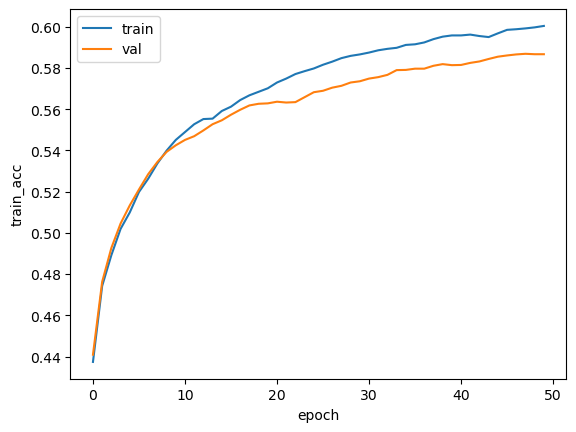

In [20]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=1, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().cuda()

print(model_tmpl)
flops = calc_model_flops(model, model_gen.in_shape)['flops']
print(round(flops / 1024 / 1024, 2), 'MFlops')

train_params = {
    'val_size': 10000,
    'batch_size': 256,
    'num_epoch': 50,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [21]:
from sophius.db import database, Experiments, Models, ModelEpochs

with database:
    database.create_tables([Experiments, Models, ModelEpochs])

exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}

exp, created = Experiments.get_or_create(**exp_params)
exp, created

(<Experiments: 1>, False)

In [22]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), out_shape=10, 
    conv_num=10, lin_num=3
)

val_acc_threshold = 0.7

for i in tqdm(range(10)):
    model_tmpl = model_gen.generate_model_tmpl()
    model = model_tmpl.instantiate_model().cuda()
    
    if estimate_acc(model_tmpl) < val_acc_threshold:
        continue
        
    epoch_results = train_on_gpu_ex(
        model=model,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    model_info = calc_model_flops(model, model_gen.in_shape)
    model = Models.create(
        exp_id = exp.id,
        hash = encoder.model2hash(model_tmpl),
        flops = model_info['flops'],
        macs = model_info['macs'],
        params = model_info['params'],
        val_acc = round(epoch_results.val_acc.iloc[-10:].mean(), 5),
        train_acc = round(epoch_results.train_acc.iloc[-10:].mean(), 5),
        time = round(epoch_results.time.iloc[-1], 1),
    )
    
    
    for _, row in epoch_results.iterrows():
        ModelEpochs.create(
            exp_id = exp.id,
            model_id = model.id,
            epoch = row['epoch'],
            loss = row['loss'],
            train_acc = row['train_acc'],
            val_acc = row['val_acc'],
            time = row['time'],
        )
    

100% 10/10 [01:11<00:00,  7.14s/it]


In [27]:
import pandas as pd

with database.connection() as conn:
    df = pd.read_sql('SELECT * from models', conn)

df[-5:]

,id,exp_id,hash,flops,macs,params,val_acc,train_acc,time
8529,8530,1,00810112200000000044a0004000000000802422080400...,16736000,8308608,118091,0.73680,0.84130,25.9
8530,8531,1,00808122100200000022c8000080841210020000008082...,60098624,29853952,346091,0.75370,0.99570,54.8
8531,8532,1,0080209110080000004460004000000000810122080800...,29196992,14526336,654218,0.75162,0.99959,70.1
8532,8533,1,0080442120000000004260004000000000255000008080...,17458848,8530368,607114,0.71510,0.98120,121.5
8533,8534,1,0080411210040000004310004000000000820422200000...,18741184,9290688,198475,0.73610,0.99810,67.2


In [28]:
with database.connection() as conn:
    exp = pd.read_sql('SELECT * from experiments', conn)
exp

,id,val_size,batch_size,num_epoch,random_seed,optimizer,opt_params,scheduler,sch_params,in_shape,out_shape
0,1,10000,256,50,42,AdamW,"{""lr"":0.001}",ExponentialLR,"{""gamma"":0.95}","(3, 32, 32)",10


In [29]:
encoder.hash2model('00804821200000000044a000400000000080809210020000400000000024d0000080880a0804000001000000', (3, 32, 32), 10)

Conv2d       (128, 31, 31)  (2, 2)   (1, 1)  
ReLU         (128, 31, 31) 
MaxPool2d    (128, 16, 16)  (3, 3)   (2, 2)  
BatchNorm2d  (128, 16, 16) 
Conv2d       (96, 9, 9)     (6, 6)   (2, 2)  
LeakyReLU    (96, 9, 9)     (0.001) 
BatchNorm2d  (96, 9, 9)    
AvgPool2d    (96, 5, 5)     (3, 3)   (2, 2)  
Conv2d       (96, 2, 2)     (2, 2)   (3, 3)  
PReLU        (96, 2, 2)    
Flatten      384           
Linear       10            